In [52]:
import os
import sys
import pickle

from matplotlib import pyplot as plt
%matplotlib inline

import torch.optim as optim
from torchinfo import summary
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchmetrics.regression import MeanSquaredError


from Dataset_loader import DatasetHandler
from autoencoder_model import *

import pandas as pd


In [53]:
dataset_root = '../EuroSAT-split/train'
handler = DatasetHandler(dataset_root)

In [54]:
# #Reduce dataset just for quick testing
# percentage_images = 0.10
percentage_images = 0.3

['River', 'SeaLake']
Dataset images: 1320 Dataset labels: 1320
Dataset sample -> ..\EuroSAT-split\train\River\River_10.tif 8


(array([600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 720.]),
 array([8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ]),
 <BarContainer object of 10 artists>)

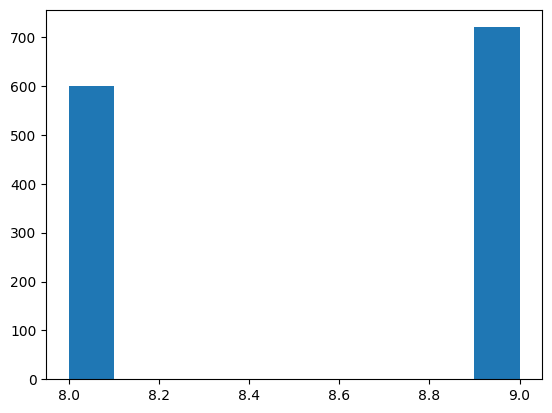

In [55]:
classes = ['River', 'SeaLake']
print(classes)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes, percentage_images=percentage_images)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

plt.hist(imgs_label, 10)

In [56]:
#Split data set 
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape) 

X_train shape: (1056,) Y_train shape: (1056,)
  X_val shape:  (264,)   Y_val shape:  (264,)


(array([600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 720.]),
 array([8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ]),
 <BarContainer object of 10 artists>)

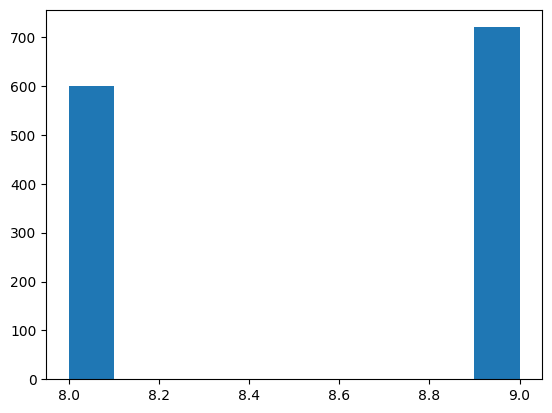

In [57]:
#Rename labels since I consider only 2 classes

for i in range(len(train_labels)):
  lr = train_labels[i]
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1
  
  train_labels[i] = l

for i in range(len(val_labels)):
  lr = val_labels[i]
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1
  
  val_labels[i] = l

plt.hist(imgs_label, 10)

In [68]:
#np.random.seed = 314

num_bands = 3
bands = [3,2,1] #for rgb reduction
# bands = list(range(num_bands))

num_qubits = 12

learning_rate = 0.0002
num_epochs = 25
batch_size = 16 #16 32
num_batches = len(train_imgs) // batch_size

method = 'small'  #Set encoder type: 'small' or 'sscnet'

# network = Net(NUM_QUBITS)#.to(device)
if method == 'small':
    network = Autoencoder_small(num_bands, num_qubits)
elif method == 'sscnet':
    network = Autoencoder_sscnet(num_bands, num_qubits)
else:
    raise Exception('Error with architecture')

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
rmse_metric = MeanSquaredError(squared=False)
ssim_metric = StructuralSimilarityIndexMeasure()
psnr_metric = PeakSignalNoiseRatio() 

maxpercentiles = [99]*num_bands
minpercentiles = [0.1]*num_bands

In [69]:
dir = './Data/{}_qubits/'.format(num_qubits)
os.makedirs(dir, exist_ok=True)

stats_file_path = dir + 'stats_{}.pkl'.format(method)
results_file_path = dir + 'results_{}.pkl'.format(method)

In [70]:
min_per_band, max_per_band, mean_per_band, pixel_values_per_band, pmin, pmax = handler.compute_dataset_stats(train_imgs, bands = bands, max_images=100, percentiles = [minpercentiles, maxpercentiles])

In [71]:
save_data = {
            'min_per_band': min_per_band,
            'max_per_band': max_per_band,
            'mean_per_band': mean_per_band, 
            'pmin': pmin,
            'pmax': pmax,
                }

with open(stats_file_path, 'wb') as f:
    pickle.dump(save_data, f)

print('Write sucessfully to ' + dir)

Write sucessfully to ./Data/12_qubits/


 Band  Min  0.1st %  Mean  99th %   Max
    3  200      229   619    1814 18892
    2  374      423   859    1663 14632
    1  552      694   998    1641 14924


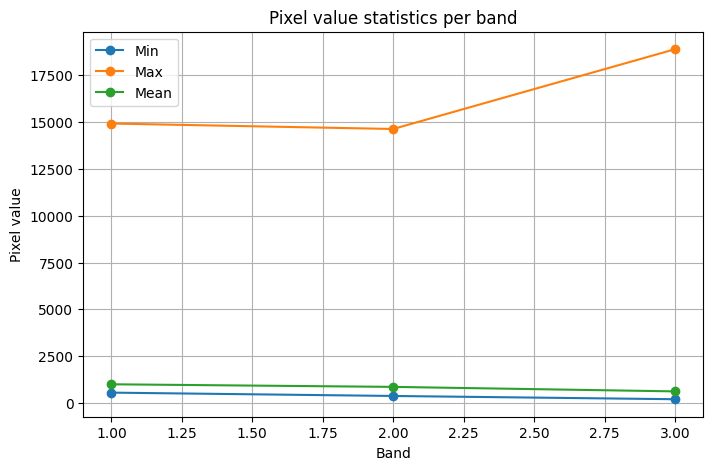

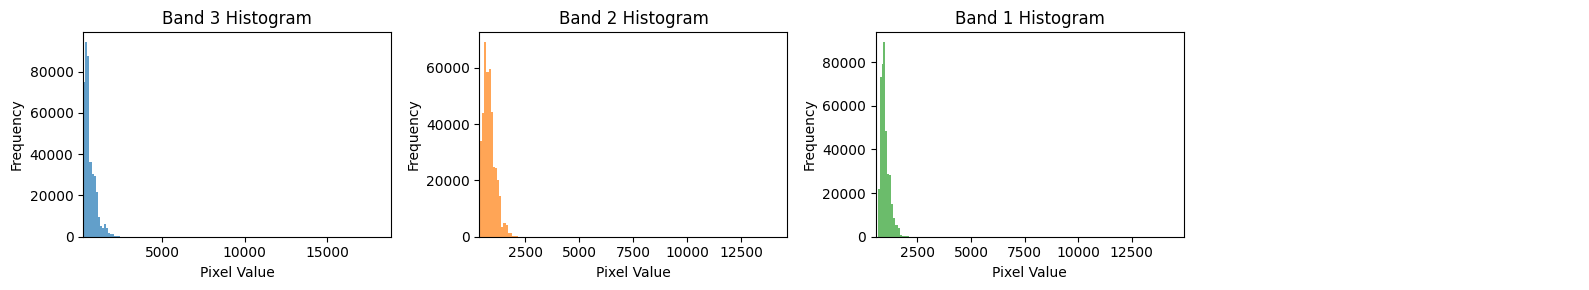

In [72]:
stats_df = pd.DataFrame({
    'Band': bands,
    'Min': min_per_band,
    f'{minpercentiles[0]}st %': pmin,
    'Mean': mean_per_band,
    f'{maxpercentiles[0]}th %': pmax,
    'Max': max_per_band
})

print(stats_df.round(0).astype(int).to_string(index=False))

# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [73]:
train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = batch_size, img_shape = (64,64,num_bands), bands = bands)) # 3 for grb reduciton
test_loader = iter(handler.ms_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = (64,64,num_bands), bands = bands ))

 Band  Min  Mean  Max
    3  0.0  0.25  1.0
    2  0.0  0.36  1.0
    1  0.0  0.32  1.0


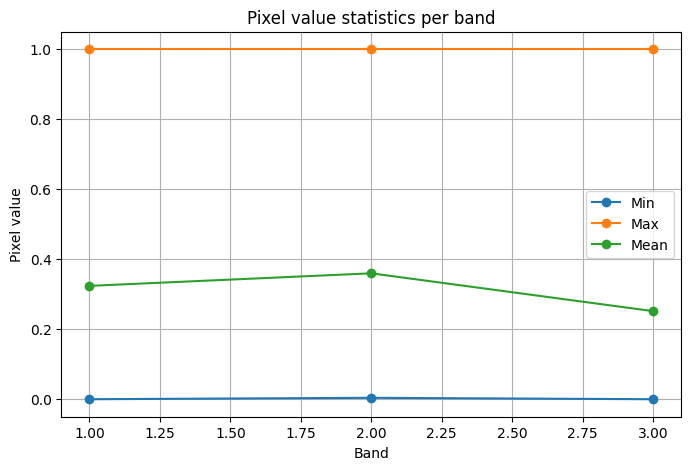

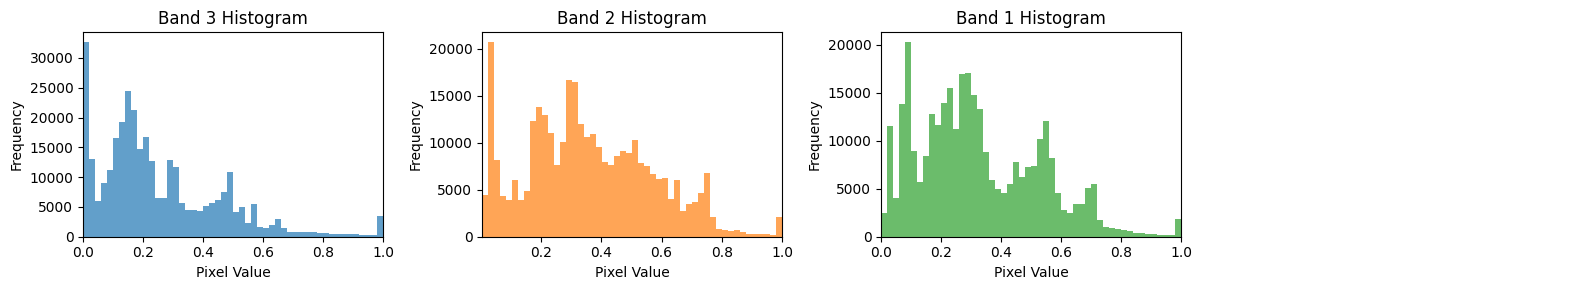

In [74]:
#JUST TO DOUBLE CHECK TRAIN

min_per_band, max_per_band, mean_per_band, pixel_values_per_band = handler.compute_stats_tocheck(loader = train_loader, bands=list(range(num_bands)), max_images=100)

stats_df = pd.DataFrame({
    'Band': bands,
    'Min': min_per_band,
    'Mean': mean_per_band,
    'Max': max_per_band
})

print(stats_df.round(2).to_string(index=False))

# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

 Band  Min  Mean  Max
    3  0.0  0.20  1.0
    2  0.0  0.33  1.0
    1  0.0  0.29  1.0


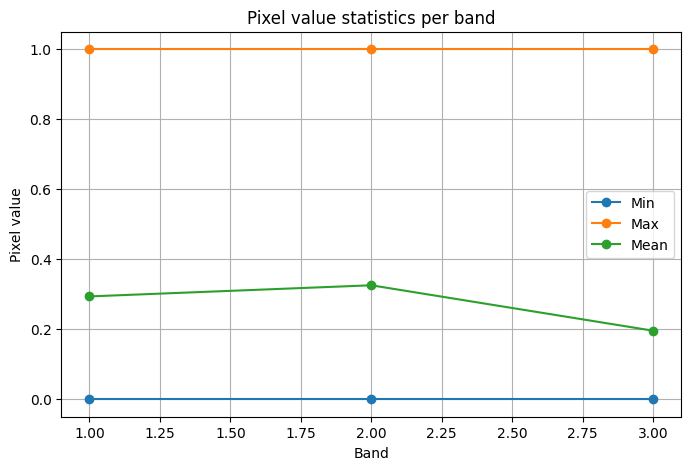

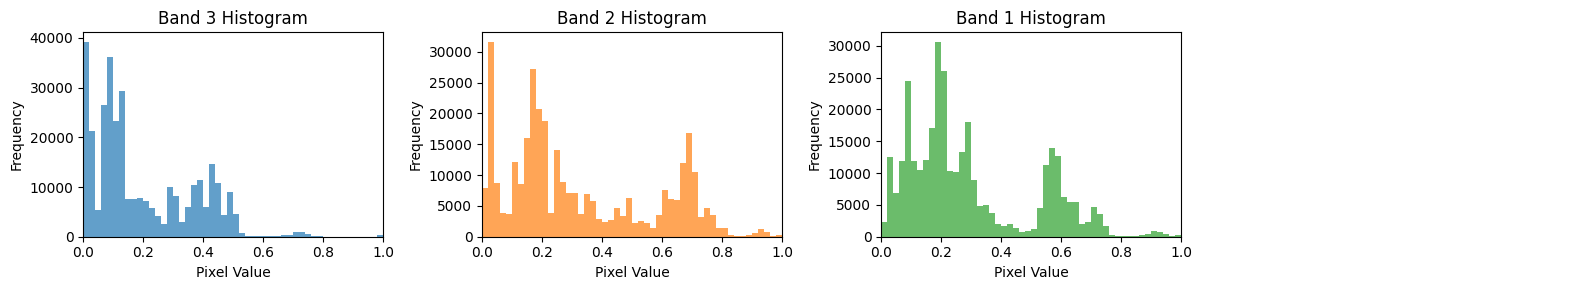

In [75]:
#JUST TO DOUBLE CHECK TEST

min_per_band, max_per_band, mean_per_band, pixel_values_per_band = handler.compute_stats_tocheck(loader = test_loader, bands=list(range(num_bands)), max_images=100)

stats_df = pd.DataFrame({
    'Band': bands,
    'Min': min_per_band,
    'Mean': mean_per_band,
    'Max': max_per_band
})

print(stats_df.round(2).to_string(index=False))

# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [76]:
# Get one batch from the train_loader
images, labels = next(train_loader)

# Print the shape of the images
print("Input size:", images.shape)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters:", count_parameters(network))
summary(network, input_size=images.shape)

Input size: torch.Size([16, 3, 64, 64])
Number of trainable parameters: 71935


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_small                        [16, 3, 64, 64]           --
├─Sequential: 1-1                        [16, 12]                  --
│    └─Conv2d: 2-1                       [16, 16, 64, 64]          448
│    └─ReLU: 2-2                         [16, 16, 64, 64]          --
│    └─MaxPool2d: 2-3                    [16, 16, 32, 32]          --
│    └─Conv2d: 2-4                       [16, 32, 32, 32]          4,640
│    └─ReLU: 2-5                         [16, 32, 32, 32]          --
│    └─MaxPool2d: 2-6                    [16, 32, 16, 16]          --
│    └─Conv2d: 2-7                       [16, 32, 16, 16]          9,248
│    └─ReLU: 2-8                         [16, 32, 16, 16]          --
│    └─MaxPool2d: 2-9                    [16, 32, 8, 8]            --
│    └─Flatten: 2-10                     [16, 2048]                --
│    └─Linear: 2-11                      [16, 12]                  24,588
├─Se

In [77]:
train_loss_list = []
val_loss_list = []

train_rmse_list = []
val_rmse_list = []
train_ssim_list = []
val_ssim_list = []
train_psnr_list = []
val_psnr_list = []

for epoch in range(num_epochs):

    total_loss = []
    
    train_targets = []
    train_predictions = []

    network.train()
    # for batch_idx in range(len(train_labels)):
        # Itera direttamente sui batch del DataLoader
    for batch_idx in range(num_batches):
        images, _ = next(train_loader) 
        outputs = network(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

        
        train_targets.append(images.detach())
        train_predictions.append(outputs.detach())

        print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (
            epoch, batch_idx, num_batches-1, loss.item()), end='\t\t')
    
    network.eval()
    with torch.no_grad():
        val_loss = []
        targets = []
        predictions = []
        for batch_idx in range(len(val_images)):
            data, _ = next(test_loader)
            output = network(data)
            loss = criterion(output, data)

            val_loss.append(loss.item())

            targets.append(data)
            predictions.append(output)

    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))
  
    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / num_epochs, train_loss_list[-1], val_loss_list[-1]))
    
    if epoch % 3 == 1:

            # Concatenate all batches into single tensors
        targets = torch.cat(targets, dim=0)
        predictions = torch.cat(predictions, dim=0)

        train_targets = torch.cat(train_targets, dim=0)
        train_predictions = torch.cat(train_predictions, dim=0)

        rt = rmse_metric(train_predictions, train_targets)
        rv = rmse_metric(predictions, targets)
        st = ssim_metric(train_predictions, train_targets)
        sv = ssim_metric(predictions, targets)
        pt = psnr_metric(train_predictions, train_targets)
        pv = psnr_metric(predictions, targets)      

        print('RMSE: ', 'train: ' , rt,'val: ' , rv)
        print('SSIM: ', 'train: ' , st, 'val: ' , sv)
        print('PSNR: ', 'train: ' , pt, 'val: ' ,  pv)

        train_rmse_list.append(rt)
        val_rmse_list.append(rv)
        train_ssim_list.append(st)
        val_ssim_list.append(sv)
        train_psnr_list.append(pt)
        val_psnr_list.append(pv)


 Epoch 0 ~ Batch 65 (65) ~ Loss 0.068291 		Training [4%]	 Training Loss: 0.0801 Validation Loss: 0.0751
 Epoch 1 ~ Batch 65 (65) ~ Loss 0.026100 		Training [8%]	 Training Loss: 0.0426 Validation Loss: 0.0137
RMSE:  train:  tensor(0.2063) val:  tensor(0.1173)
SSIM:  train:  tensor(0.1674) val:  tensor(0.3895)
PSNR:  train:  tensor(13.7102) val:  tensor(18.6175)
 Epoch 2 ~ Batch 65 (65) ~ Loss 0.017165 		Training [12%]	 Training Loss: 0.0242 Validation Loss: 0.0112
 Epoch 3 ~ Batch 65 (65) ~ Loss 0.019796 		Training [16%]	 Training Loss: 0.0218 Validation Loss: 0.0098
 Epoch 4 ~ Batch 65 (65) ~ Loss 0.014764 		Training [20%]	 Training Loss: 0.0229 Validation Loss: 0.0087
RMSE:  train:  tensor(0.1513) val:  tensor(0.0934)
SSIM:  train:  tensor(0.4396) val:  tensor(0.6424)
PSNR:  train:  tensor(16.4006) val:  tensor(20.5975)
 Epoch 5 ~ Batch 65 (65) ~ Loss 0.027002 		Training [24%]	 Training Loss: 0.0201 Validation Loss: 0.0082
 Epoch 6 ~ Batch 65 (65) ~ Loss 0.021416 		Training [28%]	 Tra

In [78]:
save_data = {
            'train_rmse_list' : train_rmse_list,
            'val_rmse_list' : val_rmse_list,
            'train_ssim_list' : train_ssim_list,
            'val_ssim_list' : val_ssim_list,
            'train_psnr_list' : train_psnr_list,
            'val_psnr_list' : val_psnr_list
                }

with open(results_file_path, 'wb') as f:
    pickle.dump(save_data, f)

torch.save(network.state_dict(), dir + "model_weights_{}.pth".format(method))

print('Write sucessfully to ' + dir)

Write sucessfully to ./Data/12_qubits/


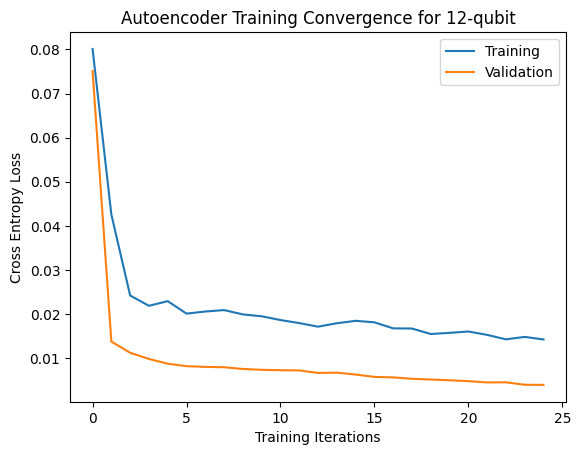

In [79]:
# fig, plt.plot(train_loss_list)
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Autoencoder Training Convergence for {}-qubit'.format(num_qubits))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])

plt.show()

RMSE:  train:  tensor(0.1193) val:  tensor(0.0670)
SSIM:  train:  tensor(0.5574) val:  tensor(0.8035)
PSNR:  train:  tensor(18.4653) val:  tensor(23.4754)


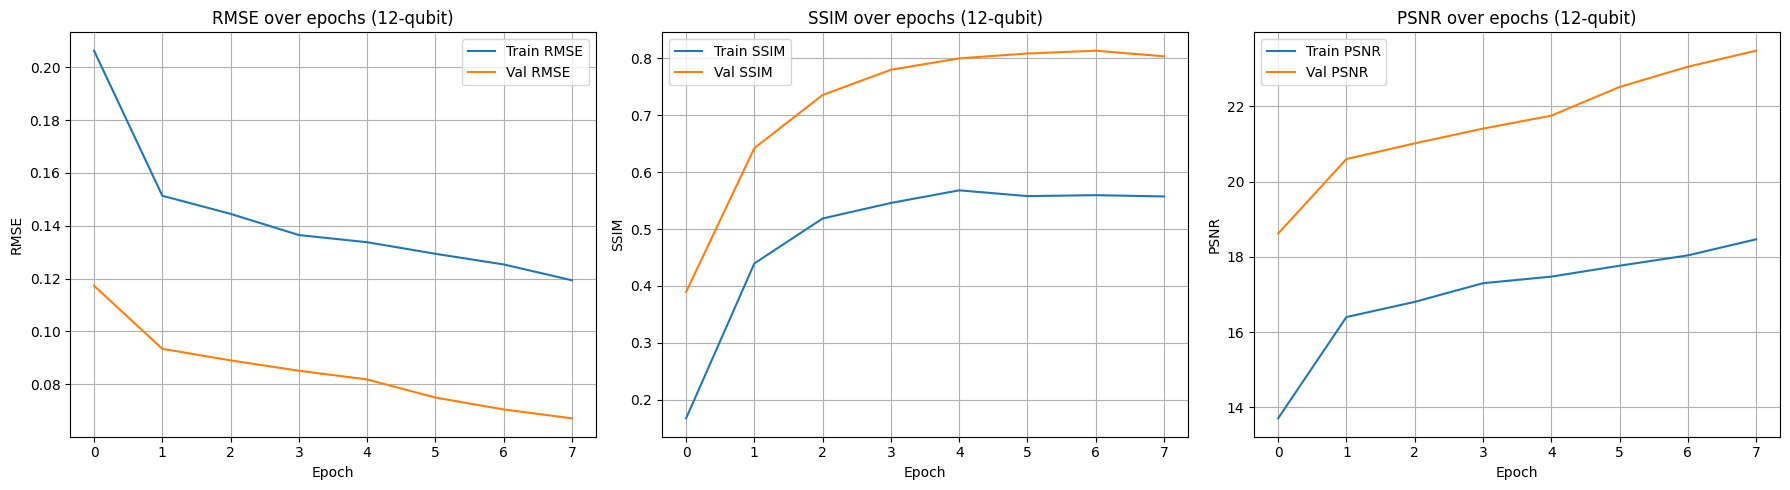

In [80]:
print('RMSE: ', 'train: ' , rt,'val: ' , rv)
print('SSIM: ', 'train: ' , st, 'val: ' , sv)
print('PSNR: ', 'train: ' , pt, 'val: ' ,  pv)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# RMSE plot
axs[0].plot([x.item() for x in train_rmse_list], label='Train RMSE')
axs[0].plot([x.item() for x in val_rmse_list], label='Val RMSE')
axs[0].set_title(f'RMSE over epochs ({num_qubits}-qubit)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('RMSE')
axs[0].legend()
axs[0].grid(True)

# SSIM plot
axs[1].plot([x.item() for x in train_ssim_list], label='Train SSIM')
axs[1].plot([x.item() for x in val_ssim_list], label='Val SSIM')
axs[1].set_title(f'SSIM over epochs ({num_qubits}-qubit)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].grid(True)

# PSNR plot
axs[2].plot([x.item() for x in train_psnr_list], label='Train PSNR')
axs[2].plot([x.item() for x in val_psnr_list], label='Val PSNR')
axs[2].set_title(f'PSNR over epochs ({num_qubits}-qubit)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('PSNR')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

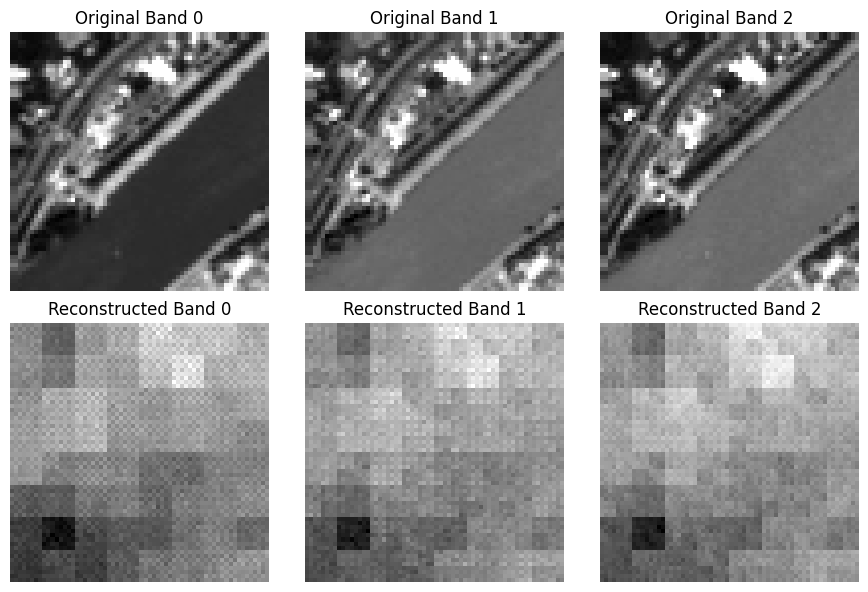

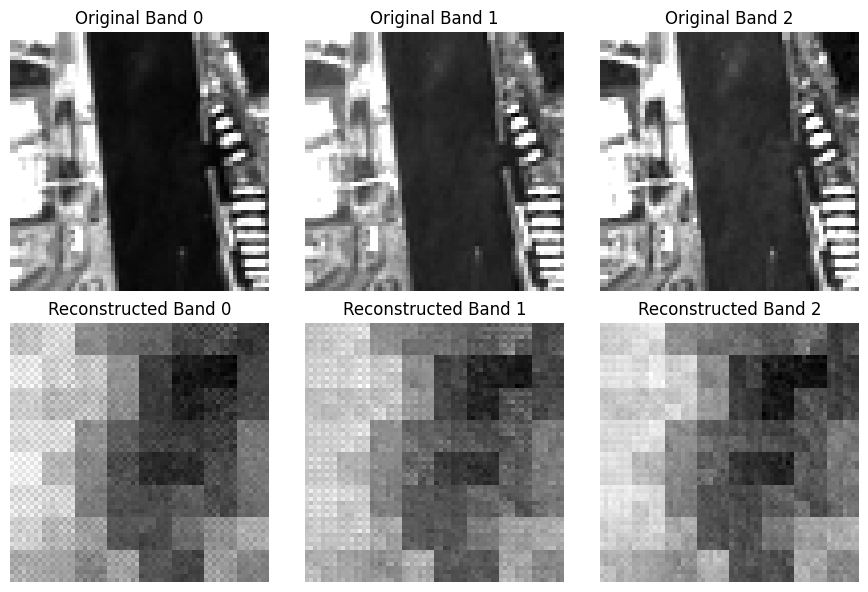

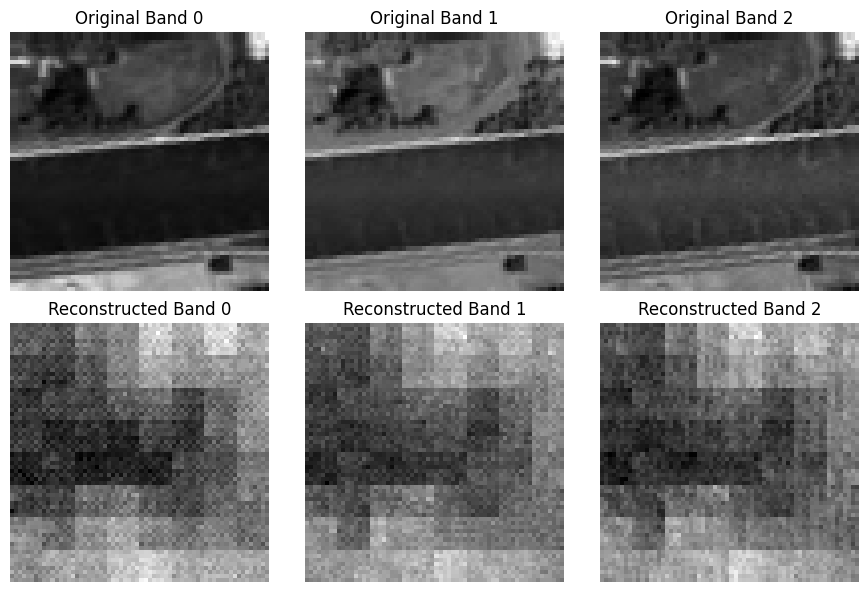

In [81]:
#TRAIN

if isinstance(train_targets, list):
    train_targets = torch.cat(train_targets, dim=0)
    train_predictions = torch.cat(train_predictions, dim=0)

n_samples = 3

n_bands = train_targets.shape[1]
for i in range(n_samples):
    fig, axs = plt.subplots(2, n_bands, figsize=(3*n_bands, 6))
    for b in range(n_bands):
        axs[0, b].imshow(train_targets[i, b].numpy(), cmap='gray')
        axs[0, b].set_title(f'Original Band {b}')
        axs[0, b].axis('off')

        axs[1, b].imshow(train_predictions[i, b].numpy(), cmap='gray')
        axs[1, b].set_title(f'Reconstructed Band {b}')
        axs[1, b].axis('off')
    plt.tight_layout()
    plt.show()

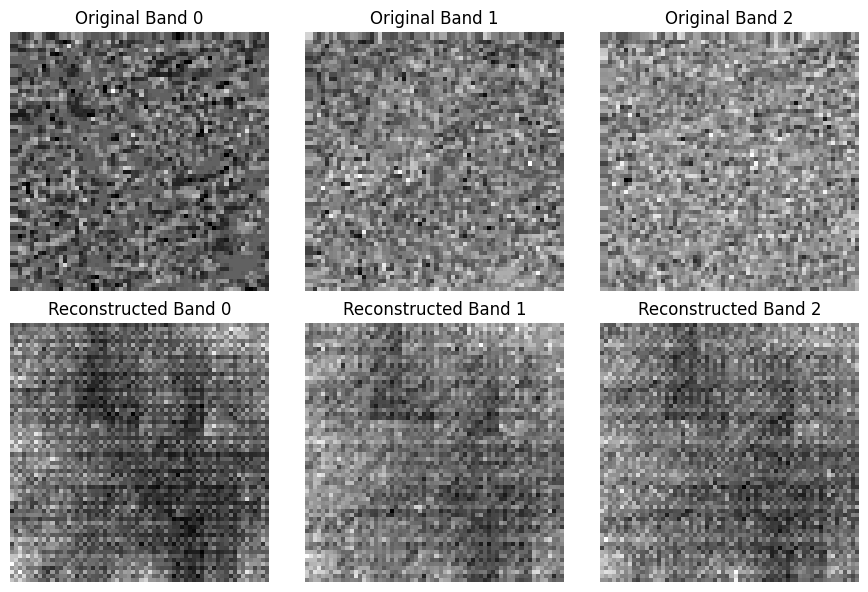

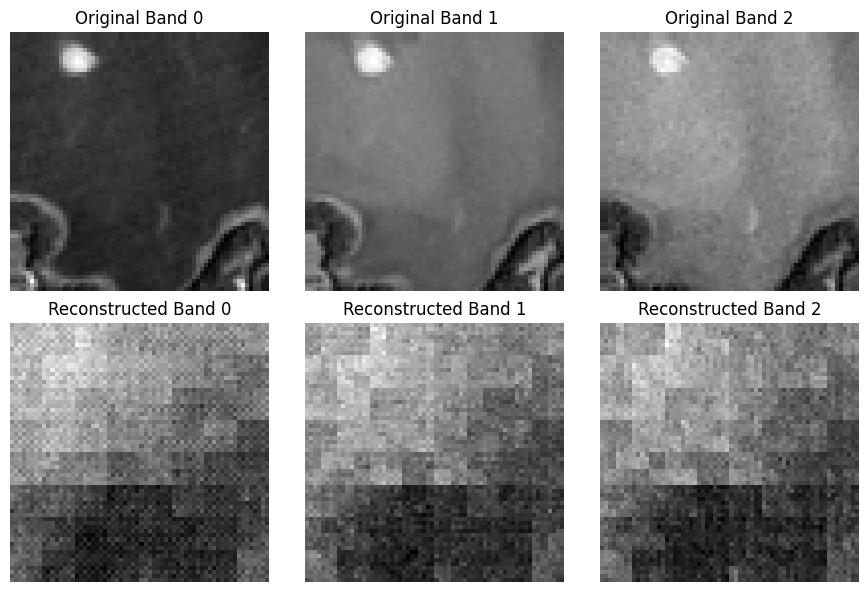

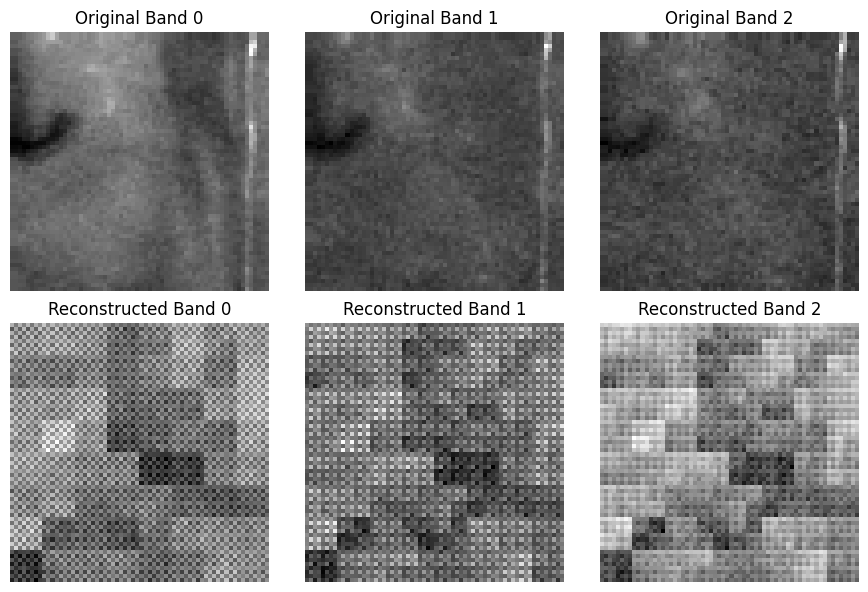

In [82]:
#VALIDATION

if isinstance(targets, list):
    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)

n_samples = 3

n_bands = targets.shape[1]
for i in range(n_samples):
    fig, axs = plt.subplots(2, n_bands, figsize=(3*n_bands, 6))
    for b in range(n_bands):
        axs[0, b].imshow(targets[i, b].numpy(), cmap='gray')
        axs[0, b].set_title(f'Original Band {b}')
        axs[0, b].axis('off')

        axs[1, b].imshow(predictions[i, b].numpy(), cmap='gray')
        axs[1, b].set_title(f'Reconstructed Band {b}')
        axs[1, b].axis('off')
    plt.tight_layout()
    plt.show()

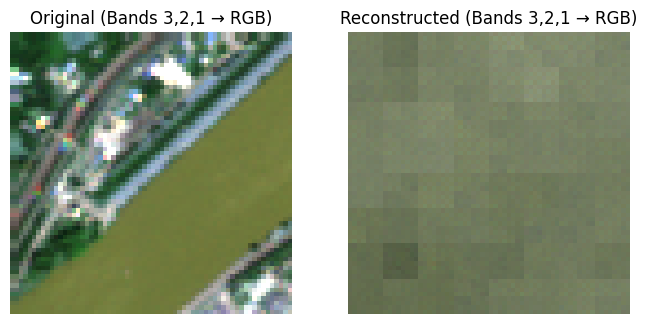

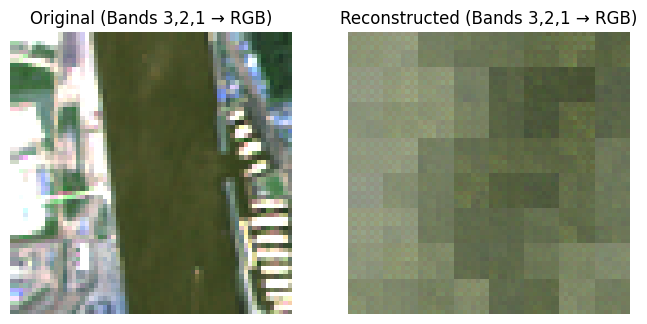

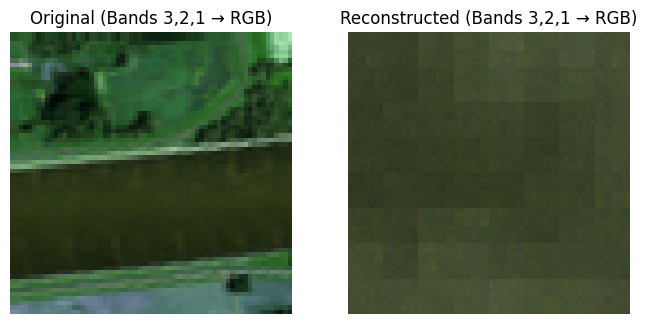

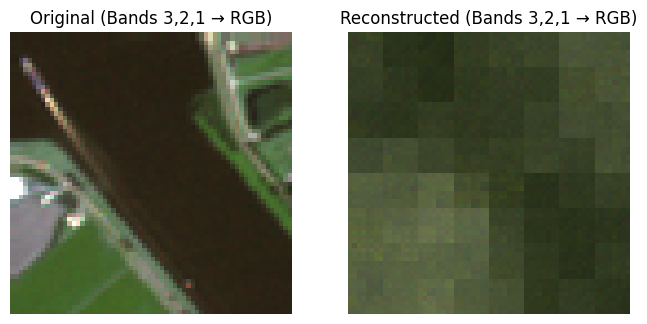

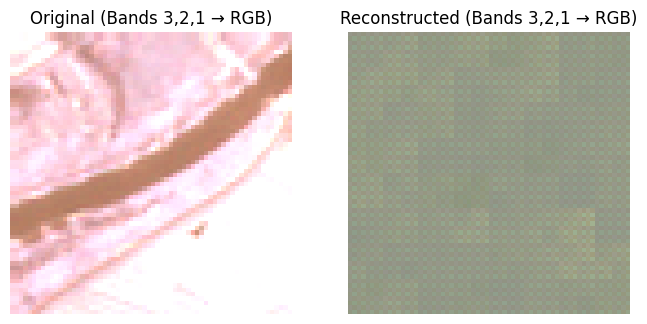

In [83]:
#TRAIN

if isinstance(train_targets, list):
    train_targets = torch.cat(train_targets, dim=0)
    train_predictions = torch.cat(train_predictions, dim=0)

n_samples = 5
for i in range(n_samples):
    img = train_targets[i].permute(1, 2, 0).numpy()
    recon = train_predictions[i].permute(1, 2, 0).numpy()

    # Ensure at least 3 bands exist
    if img.shape[2] >= 3:
        img_rgb = img[:, :, [2, 1, 0]]  # Bands 3,2,1 → R,G,B
        recon_rgb = recon[:, :, [2, 1, 0]]
    else:
        img_rgb = img
        recon_rgb = recon

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original (Bands 3,2,1 → RGB)')
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed (Bands 3,2,1 → RGB)')
    plt.imshow(recon_rgb)
    plt.axis('off')
    plt.show()

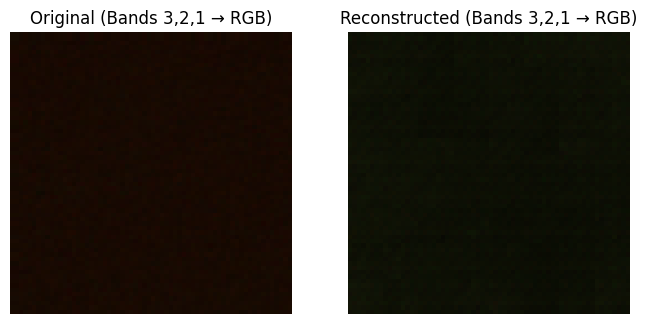

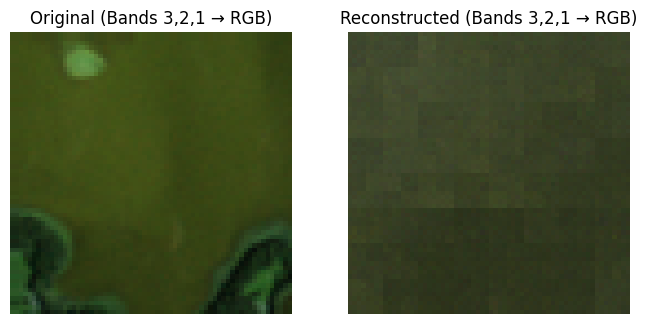

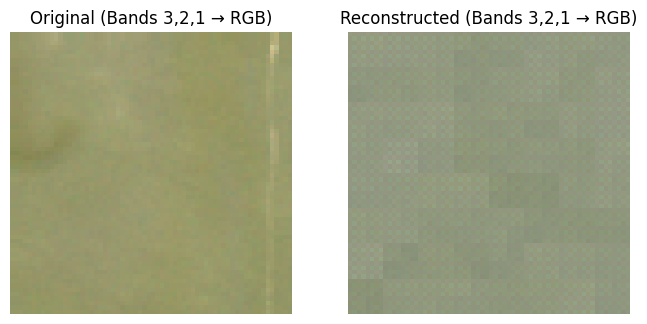

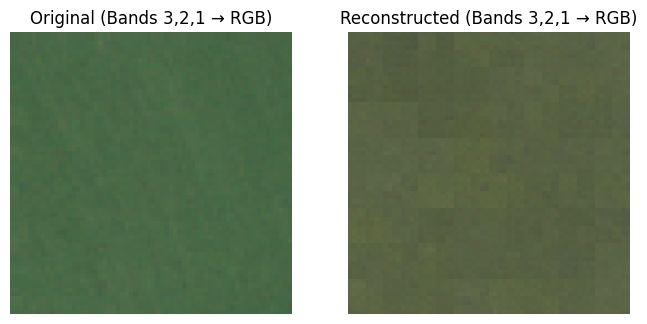

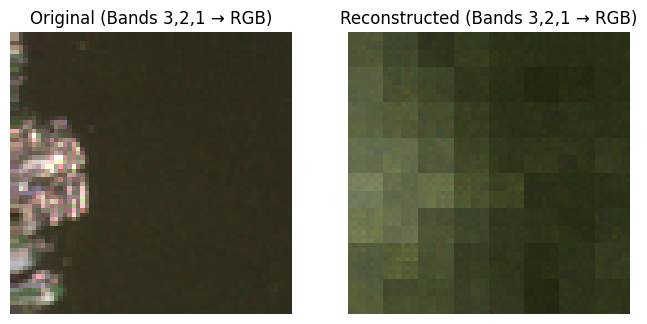

In [84]:
#VALIDATION

if isinstance(targets, list):
    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)

n_samples = 5
for i in range(n_samples):
    img = targets[i].permute(1, 2, 0).numpy()
    recon = predictions[i].permute(1, 2, 0).numpy()

    # Ensure at least 3 bands exist
    if img.shape[2] >= 3:
        img_rgb = img[:, :, [2, 1, 0]]  # Bands 3,2,1 → R,G,B
        recon_rgb = recon[:, :, [2, 1, 0]]
    else:
        img_rgb = img
        recon_rgb = recon

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original (Bands 3,2,1 → RGB)')
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed (Bands 3,2,1 → RGB)')
    plt.imshow(recon_rgb)
    plt.axis('off')
    plt.show()

In [85]:
# # Load the .pth file
# data = torch.load("10_qubits/model_weights.pth", map_location=torch.device('cpu'))  # 'cpu' if you saved on GPU but want to inspect on CPU

# # # If it's a state_dict (common case), it's an OrderedDict of layer names and tensors
# # print(type(data))
# # for key, value in data.items():
# #     print(f"{key} → shape: {value.shape}")
# total_params = sum(v.numel() for v in data.values())
# print(f"Total parameters in state_dict: {total_params}")


# print('RMSE: ', 'train: ' , rt,'val: ' , rv)
# print('SSIM: ', 'train: ' , st, 'val: ' , sv)
# print('PSNR: ', 'train: ' , pt, 'val: ' ,  pv)

# plt.plot([x.item() for x in train_rmse_list])
# plt.plot([x.item() for x in val_rmse_list])
# plt.title('Train RMSE over epochs for {}-qubit'.format(num_qubits))
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.show()

# plt.plot([x.item() for x in train_ssim_list])
# plt.plot([x.item() for x in val_ssim_list])
# plt.title('Train SSIM over epochs for {}-qubit'.format(num_qubits))
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.show()

# plt.plot([x.item() for x in train_psnr_list])
# plt.plot([x.item() for x in val_psnr_list])
# plt.title('Train PSNR over epochs for {}-qubit'.format(num_qubits))
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.show()

In [86]:
# input, _ = next(train_loader)
# print(input.shape)

# network.eval()
# with torch.no_grad():
#     output_np = network(input).detach().numpy()
# print(output.shape)
# input_np = input.detach().numpy()

# for i in range(3):
#     fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#     axes[0].imshow(input_np[0, i, :, :] - output_np[0, i, :, :], cmap='gray')
#     axes[0].set_title(f'Diff Band {i}')
#     axes[0].axis('off')
#     plt.colorbar(axes[0].imshow(input_np[0, i, :, :] - output_np[0, i, :, :], cmap='gray'), ax=axes[0])

#     axes[1].imshow(input_np[0, i, :, :], cmap='gray')
#     axes[1].set_title(f'Input Band {i}')
#     axes[1].axis('off')
#     plt.colorbar(axes[1].imshow(input_np[0, i, :, :], cmap='gray'), ax=axes[1])

#     axes[2].imshow(output_np[0, i, :, :], cmap='gray')
#     axes[2].set_title(f'Output Band {i}')
#     axes[2].axis('off')
#     plt.colorbar(axes[2].imshow(output_np[0, i, :, :], cmap='gray'), ax=axes[2])

#     plt.tight_layout()
#     plt.show()